[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MisaOgura/flashtorch/blob/master/examples/activation_maximization_colab.ipynb)

## Activation maximization

---

[Activation maximization](https://pdfs.semanticscholar.org/65d9/94fb778a8d9e0f632659fb33a082949a50d3.pdf) is one form of feature visualization that allows us to visualize what CNN filters are "looking for", by applying each filter to an input image and updating the input image so as to maximize the activation of the filter of interest (i.e. treating it as a gradient ascent task with filter activation values as the loss).

The optimization and visualization is available via `flashtorch.activmax.GradientAscent`. The implementation is inspired by [this demo](https://blog.keras.io/category/demo.html) by Francois Chollet.

from https://github.com/MisaOgura/flashtorch run under pyFlashTorch

### 0. Set up

In [2]:
# Install flashtorch if you don't have it

!pip install flashtorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for flashtorch: filename=flashtorch-0.1.3-py3-none-any.whl size=26247 sha256=74003973d0554309bbabda0ba115d0612180b00abb4a2c0040ea1617da8ff9e4
  Stored in directory: /root/.cache/pip/wheels/62/7a/fd/e186c4584835bf57e3b56f8470c018af80c0ac1f5723b4262a
Successfully built flashtorch


In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torchvision.models as models

from flashtorch.activmax import GradientAscent

### 1. Load a pre-trained Model

In [4]:
model = models.vgg16(pretrained=True)

# Print layers and corresponding indicies

list(model.features.named_children())

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

[('0', Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('1', ReLU(inplace=True)),
 ('2', Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('3', ReLU(inplace=True)),
 ('4',
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)),
 ('5', Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('6', ReLU(inplace=True)),
 ('7', Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('8', ReLU(inplace=True)),
 ('9',
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)),
 ('10', Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('11', ReLU(inplace=True)),
 ('12', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('13', ReLU(inplace=True)),
 ('14', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('15', ReLU(inplace=True)),
 ('16',
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)),
 ('17'

### 2. Specify layers and filters

In [5]:
conv1_2 = model.features[2]
conv1_2_filters = [17, 33, 34, 57]

conv2_1 = model.features[5]
conv2_1_filters = [27, 40, 68, 73]

conv3_1 = model.features[10]
conv3_1_filters = [31, 61, 147, 182]

conv4_1 = model.features[17]
conv4_1_filters = [238, 251, 338, 495]

conv5_1 = model.features[24]
conv5_1_filters = [45, 271, 363, 409]

### 3. Optimize and visualize filters

Creating an instance of `GradientAscent` class with the model _without fully-connected layers_ allows us to use flexible input image sizes.

In [6]:
g_ascent = GradientAscent(model.features)

By calling the `visualize` method and passing in the layer and filter indeciies defined above, it performs optimization and visualization.

This is perhaps the most common way to use the `GradientAscent` class, but there are other APIs available according to your use cases (see section 4).

In [7]:
g_ascent.visualize(conv1_2, conv1_2_filters, title='conv1_2');
g_ascent.visualize(conv2_1, conv2_1_filters, title='conv2_1');
g_ascent.visualize(conv3_1, conv3_1_filters, title='conv3_1');
g_ascent.visualize(conv4_1, conv4_1_filters, title='conv4_1');
g_ascent.visualize(conv5_1, conv5_1_filters, title='conv5_1');

Output hidden; open in https://colab.research.google.com to view.

We can see that, in the earlier layers (conv1_2, conv2_1), filters get activated by colors and simple patterns such as virtical, horisontal and diagonal lines.

In the intermediate layers (conv3_1, conv4_1), we start to see more complex patterns.

Then oncepts like 'eye' (filter 45) and 'entrance (?)' (filter 271) seem to appear in the last layer (conv5_1).

### 4. Other ways to use `GradientAscent`

#### 4-1. `GradientAscent.visualize`: randomly select filters

If you have a convolutional layer you want to vizualise, but you don't know which filters to choose, you can just pass in the layer to `visualize` without `filter_idxs`. It will randomly choose filters. You can adjust the number of filters chosen by passing `num_subplots` (default=4).

In [8]:
g_ascent.visualize(conv5_1, title='Randomly selected filters from conv5_1');

Output hidden; open in https://colab.research.google.com to view.

#### 4-2. `GradientAscent.visualize`: plot one filter

If you just want to visualize one filter, you can do so by specifying the filter index as an integer, not a list.

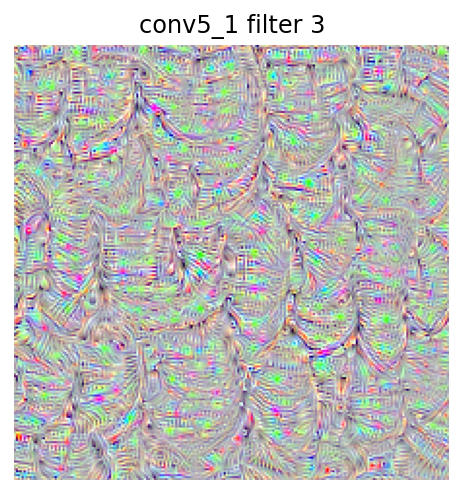

In [9]:
g_ascent.visualize(conv5_1, 3, title='conv5_1 filter 3');

#### 4-3. `GradientAscent.visualize`: return image tensor

If you want to grab the optimized image data, set `return_output` to `True`.

num_iter: 30
optimized image: torch.Size([1, 3, 224, 224])


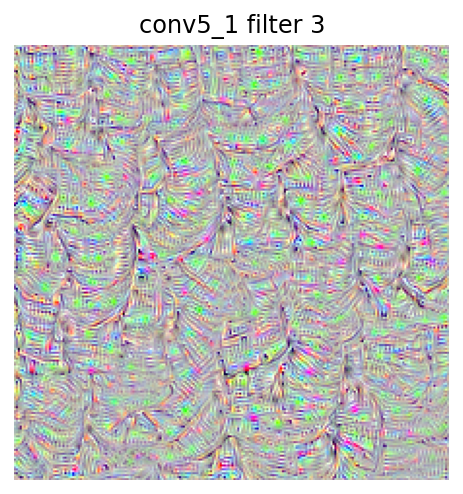

In [10]:
output = g_ascent.visualize(conv5_1, 3, title='conv5_1 filter 3', return_output=True);

print('num_iter:', len(output))
print('optimized image:', output[-1].shape)

#### 4-4. `GradientAscent.deepdream`: create DeepDream

You can create a [DeepDream](https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html) by supplying a path to your own image.

This will optimize the supplied image, instead of a random input noise, with regards to the filter specidied.

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
cd /content/drive/MyDrive/teaching/CS827/my practicals/

/content/drive/MyDrive/teaching/CS827/my practicals


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


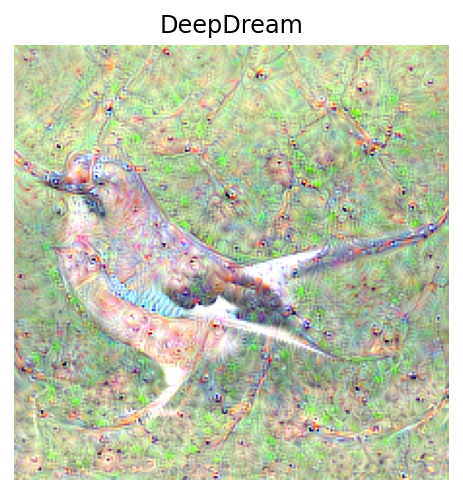

In [19]:
g_ascent.deepdream('./images/jay.jpg', conv5_1, 33)

#### 4-5. `GradientAscent.optimize`: perform optimization only (no visualization)

If no visualization is needed, or if you want to futher customize visualization, you can call the `optimize` method directly.

In [20]:
output = g_ascent.optimize(conv5_1, 3)

print('num_iter:', len(output))
print('optimized image:', output[-1].shape)

num_iter: 30
optimized image: torch.Size([1, 3, 224, 224])
